# EDA: динамическое ценообразование (train/test)

Цели:
- проверить качество данных (пропуски, дубликаты, валидность интервалов),
- детально описать каждый признак и сравнить train/test,
- выявить распределительные сдвиги.


In [41]:
import pandas as pd
import numpy as np
from IPython.display import display

try:
    import matplotlib.pyplot as plt
except ImportError as exc:
    raise ImportError("Нужен matplotlib для построения графиков. Установите: pip install matplotlib") from exc

pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 200)
pd.set_option("display.float_format", "{:.6f}".format)


# --- вспомогательные функции ---

def summary_stats(df, cols):
    return pd.DataFrame({
        "min": df[cols].min(),
        "p05": df[cols].quantile(0.05),
        "p25": df[cols].quantile(0.25),
        "median": df[cols].median(),
        "p75": df[cols].quantile(0.75),
        "p95": df[cols].quantile(0.95),
        "max": df[cols].max(),
        "mean": df[cols].mean(),
        "std": df[cols].std(),
    })


def psi_numeric(expected, actual, bins=10):
    expected = np.asarray(expected)
    actual = np.asarray(actual)
    quantiles = np.linspace(0, 1, bins + 1)
    breakpoints = np.unique(np.quantile(expected, quantiles))
    if len(breakpoints) < 3:
        return np.nan
    expected_counts, _ = np.histogram(expected, bins=breakpoints)
    actual_counts, _ = np.histogram(actual, bins=breakpoints)
    expected_perc = expected_counts / expected_counts.sum()
    actual_perc = actual_counts / actual_counts.sum()
    epsilon = 1e-6
    expected_perc = np.where(expected_perc == 0, epsilon, expected_perc)
    actual_perc = np.where(actual_perc == 0, epsilon, actual_perc)
    return np.sum((expected_perc - actual_perc) * np.log(expected_perc / actual_perc))


def psi_categorical(expected, actual):
    expected = pd.Series(expected)
    actual = pd.Series(actual)
    all_cats = pd.Index(expected.unique()).union(actual.unique())
    expected_counts = expected.value_counts().reindex(all_cats, fill_value=0)
    actual_counts = actual.value_counts().reindex(all_cats, fill_value=0)
    expected_perc = expected_counts / expected_counts.sum()
    actual_perc = actual_counts / actual_counts.sum()
    epsilon = 1e-6
    expected_perc = expected_perc.replace(0, epsilon)
    actual_perc = actual_perc.replace(0, epsilon)
    return ((expected_perc - actual_perc) * np.log(expected_perc / actual_perc)).sum()


def freq_table(train, test, col):
    train_freq = train[col].value_counts(normalize=True).rename("train_share")
    test_freq = test[col].value_counts(normalize=True).rename("test_share")
    out = pd.concat([train_freq, test_freq], axis=1).fillna(0)
    out["diff"] = out["test_share"] - out["train_share"]
    return out.sort_index()


In [42]:
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")

train["dt"] = pd.to_datetime(train["dt"])
test["dt"] = pd.to_datetime(test["dt"])

print("train:", train.shape)
print("test:", test.shape)
print("Колонки train:")
print(train.columns.tolist())
print("Колонки test:")
print(test.columns.tolist())

train.head()


train: (29100, 19)
test: (28050, 18)
Колонки train:
['dt', 'price_p05', 'price_p95', 'n_stores', 'precpt', 'avg_temperature', 'avg_humidity', 'avg_wind_level', 'holiday_flag', 'activity_flag', 'management_group_id', 'first_category_id', 'second_category_id', 'third_category_id', 'dow', 'day_of_month', 'week_of_year', 'month', 'product_id']
Колонки test:
['dt', 'n_stores', 'precpt', 'avg_temperature', 'avg_humidity', 'avg_wind_level', 'holiday_flag', 'activity_flag', 'management_group_id', 'first_category_id', 'second_category_id', 'third_category_id', 'dow', 'day_of_month', 'week_of_year', 'month', 'product_id', 'row_id']


,dt,price_p05,price_p95,n_stores,precpt,avg_temperature,avg_humidity,avg_wind_level,holiday_flag,activity_flag,management_group_id,first_category_id,second_category_id,third_category_id,dow,day_of_month,week_of_year,month,product_id
0,2024-03-28,1.136102,1.167625,-0.588881,-0.298690,-1.936029,0.621756,-0.439349,0,0,6,8,2,76,3,28,13,3,0
1,2024-03-29,1.133129,1.133590,-0.646402,0.074779,-2.090906,0.756995,-0.759561,0,0,6,8,33,77,4,29,13,3,0
2,2024-03-30,1.134522,1.165849,-0.636272,-0.644614,-1.825121,0.577839,0.122226,1,0,6,8,72,76,5,30,13,3,0
3,2024-03-31,1.152592,1.153091,-0.579004,-0.614834,-1.817634,0.589653,-0.520220,1,0,6,8,21,77,6,31,13,3,0
4,2024-04-01,1.166641,1.167096,-0.623265,-0.116090,-1.892973,0.689895,-1.036820,0,0,6,8,50,76,0,1,14,4,0


**Кратко по структуре:**
- train: 29100 строк, 19 колонок (включая цели `price_p05`, `price_p95`).
- test: 28050 строк, 18 колонок + `row_id` (целей нет).
- Дата `dt` присутствует в обоих наборах и будет использована как календарная ось.


In [43]:
missing = pd.DataFrame({
    "train_missing": train.isna().mean(),
    "test_missing": test.isna().mean(),
})
missing.sort_values("train_missing", ascending=False)


,train_missing,test_missing
activity_flag,0.000000,0.000000
month,0.000000,0.000000
third_category_id,0.000000,0.000000
second_category_id,0.000000,0.000000
product_id,0.000000,0.000000
price_p95,0.000000,NaN
price_p05,0.000000,NaN
precpt,0.000000,0.000000
n_stores,0.000000,0.000000
management_group_id,0.000000,0.000000


In [44]:
print("Дубликаты строк train:", train.duplicated().sum())
print("Дубликаты строк test:", test.duplicated().sum())
print("Дубликаты по ключу product_id+dt (train):", train.duplicated(["product_id", "dt"]).sum())
print("Дубликаты по ключу product_id+dt (test):", test.duplicated(["product_id", "dt"]).sum())


Дубликаты строк train: 0
Дубликаты строк test: 0
Дубликаты по ключу product_id+dt (train): 0
Дубликаты по ключу product_id+dt (test): 0


**Качество данных:** пропусков нет, дубликатов по ключу `product_id + dt` нет. Это позволяет использовать все строки без дополнительной очистки.


In [45]:
date_summary = pd.DataFrame({
    "dataset": ["train", "test"],
    "min_dt": [train["dt"].min(), test["dt"].min()],
    "max_dt": [train["dt"].max(), test["dt"].max()],
    "n_unique_dates": [train["dt"].nunique(), test["dt"].nunique()],
    "n_unique_products": [train["product_id"].nunique(), test["product_id"].nunique()],
})
date_summary


,dataset,min_dt,max_dt,n_unique_dates,n_unique_products
0,train,2024-03-28,2024-05-26,60,485
1,test,2024-03-28,2024-06-25,90,635


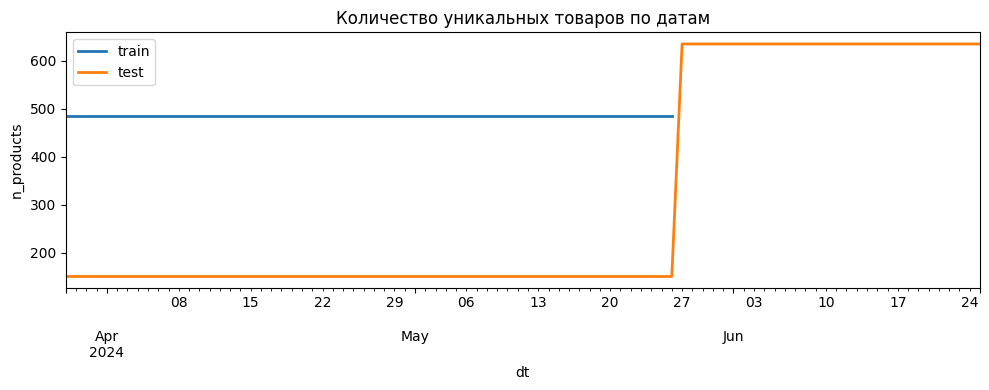

In [46]:
train_counts_by_date = train.groupby("dt")["product_id"].nunique()
test_counts_by_date = test.groupby("dt")["product_id"].nunique()

fig, ax = plt.subplots(figsize=(10, 4))
train_counts_by_date.plot(ax=ax, label="train", linewidth=2)
test_counts_by_date.plot(ax=ax, label="test", linewidth=2)
ax.set_title("Количество уникальных товаров по датам")
ax.set_xlabel("dt")
ax.set_ylabel("n_products")
ax.legend()
plt.tight_layout()


In [47]:
train_prod_days = train.groupby("product_id")["dt"].nunique()
test_prod_days = test.groupby("product_id")["dt"].nunique()

print("Дней на товар (train) min/median/max:", train_prod_days.min(), train_prod_days.median(), train_prod_days.max())
print("Дней на товар (test) min/median/max:", test_prod_days.min(), test_prod_days.median(), test_prod_days.max())

print("Распределение числа дней на товар в test:")
print(test_prod_days.value_counts().sort_index())


Дней на товар (train) min/median/max: 60 60.0 60
Дней на товар (test) min/median/max: 30 30.0 90
Распределение числа дней на товар в test:
dt
30    485
90    150
Name: count, dtype: int64


In [48]:
train_products = set(train["product_id"].unique())
test_products = set(test["product_id"].unique())

new_products = test_products - train_products
old_products = test_products & train_products

print("Новые товары в test (не встречались в train):", len(new_products))

# Старые товары в test появляются только в будущих датах (не пересекаются с train)
train_dates = set(train["dt"].unique())
old_dates_in_test = set(test.loc[test["product_id"].isin(old_products), "dt"].unique())
new_dates_in_test = set(test.loc[test["product_id"].isin(new_products), "dt"].unique())

print("Число дат для старых товаров в test:", len(old_dates_in_test))
print("Пересечение дат старых товаров с train:", len(old_dates_in_test & train_dates))
print("Число дат для новых товаров в test:", len(new_dates_in_test))
print("Пересечение дат новых товаров с train:", len(new_dates_in_test & train_dates))


Новые товары в test (не встречались в train): 150
Число дат для старых товаров в test: 30
Пересечение дат старых товаров с train: 0
Число дат для новых товаров в test: 90
Пересечение дат новых товаров с train: 60


**Временная структура и покрытие товаров:**
- `dt` в train: 2024-03-28 — 2024-05-26 (60 дат). В test: 2024-03-28 — 2024-06-25 (90 дат).
- Train — полный прямоугольник 485 товаров × 60 дат (каждый товар есть каждый день).
- Test содержит два блока:
  - 485 «старых» товаров — только в будущих 30 датах (после 2024-05-26).
  - 150 «новых» товаров — на всех 90 датах, включая пересечение с train по времени.
- Это означает одновременный сдвиг по времени и появление новых товаров в test.


In [49]:
cat_cols = [
    "management_group_id",
    "first_category_id",
    "second_category_id",
    "third_category_id",
    "dow",
    "day_of_month",
    "week_of_year",
    "month",
    "holiday_flag",
    "activity_flag",
    "product_id",
]

cat_summary = pd.DataFrame({
    "train_unique": [train[c].nunique() for c in cat_cols],
    "test_unique": [test[c].nunique() for c in cat_cols],
    "test_only": [len(set(test[c]) - set(train[c])) for c in cat_cols],
    "train_only": [len(set(train[c]) - set(test[c])) for c in cat_cols],
}, index=cat_cols)

cat_summary


,train_unique,test_unique,test_only,train_only
management_group_id,7,7,0,0
first_category_id,29,29,0,0
second_category_id,76,76,0,0
third_category_id,197,197,0,0
dow,7,7,0,0
day_of_month,31,31,0,0
week_of_year,9,14,5,0
month,3,4,1,0
holiday_flag,2,2,0,0
activity_flag,2,2,0,0


In [50]:
hier_cols = ["management_group_id", "first_category_id", "second_category_id", "third_category_id"]

var_summary = []
for col in hier_cols:
    uniq_per_product = train.groupby("product_id")[col].nunique()
    var_summary.append({
        "feature": col,
        "share_products_with_multiple_values": (uniq_per_product > 1).mean(),
        "median_unique_per_product": uniq_per_product.median(),
        "max_unique_per_product": uniq_per_product.max(),
    })

pd.DataFrame(var_summary)


,feature,share_products_with_multiple_values,median_unique_per_product,max_unique_per_product
0,management_group_id,0.851546,3.000000,7
1,first_category_id,0.969072,2.000000,2
2,second_category_id,1.000000,34.000000,42
3,third_category_id,1.000000,2.000000,2


**Иерархия и идентификаторы:**
- Уникальные значения (train/test): `management_group_id` = 7, `first_category_id` = 29, `second_category_id` = 76, `third_category_id` = 197 (в обоих наборах одинаково).
- `product_id`: 485 в train и 635 в test, из них 150 — новые (только в test).
- Важное наблюдение: у большинства товаров значения иерархических категорий меняются по датам.
  Доля товаров с более чем одним значением:
  - `management_group_id` ≈ 85.15%, медиана 3 значения на товар.
  - `first_category_id` ≈ 96.91%, медиана 2 значения на товар.
  - `second_category_id` = 100%, медиана 34 значения на товар.
  - `third_category_id` = 100%, медиана 2 значения на товар.
  Это означает, что категории ведут себя как контекстные признаки дня, а не как фиксированная характеристика товара.


In [51]:
# Распределение категорий по строкам (train/test) — топ-10 по доле
for col in hier_cols:
    tbl = freq_table(train, test, col)
    top = tbl.reindex(tbl["train_share"].sort_values(ascending=False).head(10).index)
    print(f"{col} (топ-10 по доле в train)")
    display(top)


management_group_id (топ-10 по доле в train)


,train_share,test_share,diff
management_group_id,,,
6,0.449691,0.418966,-0.030725
1,0.201306,0.234795,0.033489
2,0.113746,0.097825,-0.015920
0,0.083711,0.111087,0.027376
4,0.062234,0.055686,-0.006547
5,0.056529,0.043529,-0.013000
3,0.032784,0.038111,0.005327


first_category_id (топ-10 по доле в train)


,train_share,test_share,diff
first_category_id,,,
24,0.117732,0.140784,0.023052
23,0.109450,0.115330,0.005880
8,0.101546,0.086845,-0.014701
18,0.082577,0.054759,-0.027818
17,0.076186,0.045847,-0.030339
0,0.066460,0.035401,-0.031059
2,0.049828,0.041711,-0.008117
26,0.049416,0.074011,0.024595
20,0.047595,0.041070,-0.006525


second_category_id (топ-10 по доле в train)


,train_share,test_share,diff
second_category_id,,,
41,0.034742,0.044955,0.010213
22,0.027973,0.034652,0.006680
11,0.025945,0.020000,-0.005945
44,0.024124,0.016827,-0.007297
18,0.023608,0.017112,-0.006496
8,0.022440,0.022068,-0.000372
2,0.021890,0.030374,0.008484
75,0.019725,0.014902,-0.004823
64,0.019519,0.016471,-0.003048


third_category_id (топ-10 по доле в train)


,train_share,test_share,diff
third_category_id,,,
10,0.035292,0.017718,-0.017574
11,0.023711,0.012549,-0.011162
33,0.023540,0.012157,-0.011383
21,0.017801,0.008806,-0.008995
34,0.017560,0.012442,-0.005118
176,0.016117,0.009519,-0.006598
77,0.015636,0.007701,-0.007935
12,0.015155,0.007701,-0.007454
177,0.014914,0.009519,-0.005395


In [52]:
# Календарные признаки: распределения train/test
for col in ["month", "week_of_year", "dow", "day_of_month"]:
    print(f"{col}")
    display(freq_table(train, test, col))


month


,train_share,test_share,diff
month,,,
3,0.066667,0.021390,-0.045276
4,0.500000,0.160428,-0.339572
5,0.433333,0.252228,-0.181105
6,0.000000,0.565954,0.565954


week_of_year


,train_share,test_share,diff
week_of_year,,,
13,0.066667,0.021390,-0.045276
14,0.116667,0.037433,-0.079234
15,0.116667,0.037433,-0.079234
16,0.116667,0.037433,-0.079234
17,0.116667,0.037433,-0.079234
18,0.116667,0.037433,-0.079234
19,0.116667,0.037433,-0.079234
20,0.116667,0.037433,-0.079234
21,0.116667,0.037433,-0.079234


dow


,train_share,test_share,diff
dow,,,
0,0.133333,0.155971,0.022638
1,0.133333,0.155971,0.022638
2,0.133333,0.133333,0.000000
3,0.150000,0.138681,-0.011319
4,0.150000,0.138681,-0.011319
5,0.150000,0.138681,-0.011319
6,0.150000,0.138681,-0.011319


day_of_month


,train_share,test_share,diff
day_of_month,,,
1,0.033333,0.033333,0.000000
2,0.033333,0.033333,0.000000
3,0.033333,0.033333,0.000000
4,0.033333,0.033333,0.000000
5,0.033333,0.033333,0.000000
6,0.033333,0.033333,0.000000
7,0.033333,0.033333,0.000000
8,0.033333,0.033333,0.000000
9,0.033333,0.033333,0.000000


In [53]:
# Флаги
flags = pd.DataFrame({
    "train_mean": [train["holiday_flag"].mean(), train["activity_flag"].mean()],
    "test_mean": [test["holiday_flag"].mean(), test["activity_flag"].mean()],
}, index=["holiday_flag", "activity_flag"])
flags


,train_mean,test_mean
holiday_flag,0.366667,0.321390
activity_flag,0.548866,0.555829


**Календарные признаки и флаги:**
- `month` в train: 3–5, в test добавлен 6 (июнь).
- `week_of_year` в train: 13–21, в test: 13–26.
- `dow` и `day_of_month` покрывают все значения (0–6 и 1–31) в обоих наборах.
- Доли флагов: `holiday_flag` ≈ 0.3667 (train) vs 0.3214 (test); `activity_flag` ≈ 0.5489 (train) vs 0.5558 (test).


In [54]:
num_cols = ["n_stores", "precpt", "avg_temperature", "avg_humidity", "avg_wind_level"]

num_stats_train = summary_stats(train, num_cols).add_prefix("train_")
num_stats_test = summary_stats(test, num_cols).add_prefix("test_")
num_stats = pd.concat([num_stats_train, num_stats_test], axis=1)

num_stats


,train_min,train_p05,train_p25,train_median,train_p75,train_p95,train_max,train_mean,train_std,test_min,test_p05,test_p25,test_median,test_p75,test_p95,test_max,test_mean,test_std
n_stores,-0.749200,-0.649025,-0.582488,-0.441623,0.133566,2.088389,5.975207,-0.002295,0.989934,-0.700023,-0.511940,-0.408201,-0.254154,0.308590,2.443565,6.218397,0.170069,1.012834
precpt,-1.139015,-0.896207,-0.680611,-0.480054,-0.167565,1.974268,6.458323,-0.186648,0.961778,-1.015505,-0.679821,-0.431915,-0.071554,1.039345,2.298835,6.354048,0.360993,1.014146
avg_temperature,-2.566182,-1.772882,-1.168266,-0.498593,0.197678,0.908328,1.233543,-0.474845,0.847154,-2.437501,-1.311908,0.187175,0.920270,1.338201,1.867148,2.281394,0.660572,0.929305
avg_humidity,-3.333128,-2.606910,-0.170897,0.313721,0.532944,0.883141,1.276349,-0.050176,1.018483,-3.124323,-2.077324,-0.005682,0.533829,0.877005,1.186741,1.655064,0.220229,0.984939
avg_wind_level,-2.467447,-1.570029,-0.756115,-0.032140,0.747768,2.118372,5.164815,0.060413,1.103594,-2.290066,-1.162802,-0.521911,0.031010,0.619899,1.687526,4.177940,0.104777,0.876554


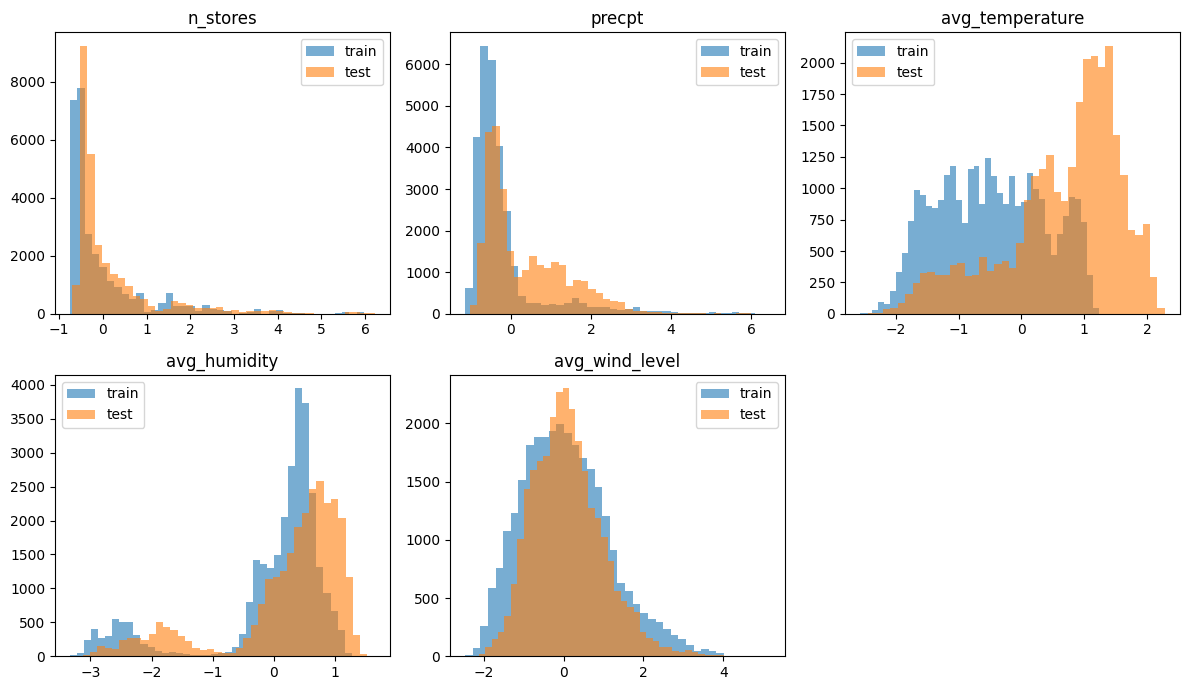

In [55]:
# Визуальное сравнение распределений
fig, axes = plt.subplots(2, 3, figsize=(12, 7))
axes = axes.ravel()

for i, col in enumerate(num_cols):
    ax = axes[i]
    ax.hist(train[col], bins=40, alpha=0.6, label="train")
    ax.hist(test[col], bins=40, alpha=0.6, label="test")
    ax.set_title(col)
    ax.legend()

axes[-1].axis("off")
plt.tight_layout()


In [56]:
# PSI для числовых признаков
psi_num = pd.DataFrame({
    "psi": [psi_numeric(train[c], test[c]) for c in num_cols]
}, index=num_cols).sort_values("psi", ascending=False)

psi_num


,psi
n_stores,1.374401
avg_temperature,0.753200
precpt,0.701887
avg_humidity,0.513743
avg_wind_level,0.132364


**Числовые контекстные признаки (`n_stores`, `precpt`, `avg_temperature`, `avg_humidity`, `avg_wind_level`):**
- Признаки выглядят стандартизированными: значения могут быть отрицательными, средние близки к 0, стандартные отклонения около 1.
- Видны распределительные сдвиги между train и test (PSI):
  - `n_stores` ≈ 1.374 (самый сильный сдвиг),
  - `avg_temperature` ≈ 0.753,
  - `precpt` ≈ 0.702,
  - `avg_humidity` ≈ 0.514,
  - `avg_wind_level` ≈ 0.132.
  Сдвиг особенно выражен в погодных признаках и `n_stores`.


In [57]:
# Проверка валидности целевых интервалов
invalid = (train["price_p05"] > train["price_p95"]).sum()
width = train["price_p95"] - train["price_p05"]

print("price_p05 > price_p95:", invalid)
print("min ширина интервала:", width.min())
print("нулевых ширин:", (width == 0).sum())

# Базовые статистики целей
price_stats = summary_stats(train, ["price_p05", "price_p95"]).add_prefix("train_")
price_stats


price_p05 > price_p95: 0
min ширина интервала: 0.0001089576554184
нулевых ширин: 0


,train_min,train_p05,train_p25,train_median,train_p75,train_p95,train_max,train_mean,train_std
price_p05,0.000000,0.672653,0.913598,1.038869,1.143169,1.204803,3.512162,1.021477,0.246938
price_p95,0.000109,0.812458,1.088465,1.142148,1.173151,1.217075,3.546587,1.116897,0.238082


In [58]:
# Ширина интервала и отношение price_p95/price_p05
ratio = train["price_p95"] / train["price_p05"].replace(0, np.nan)

width_stats = pd.Series({
    "mean": width.mean(),
    "median": width.median(),
    "p75": width.quantile(0.75),
    "p95": width.quantile(0.95),
    "p995": width.quantile(0.995),
    "p999": width.quantile(0.999),
    "max": width.max(),
})

print("Ширина интервала (ключевые квантили):")
print(width_stats)

print("Доля узких интервалов:")
for thr in [0.001, 0.01, 0.05, 0.1]:
    print(thr, (width < thr).mean())

print("price_p05 == 0:", (train["price_p05"] == 0).sum())
print("Уникальных товаров с price_p05 == 0:", train.loc[train["price_p05"] == 0, "product_id"].nunique())

print("Отношение price_p95/price_p05 (без нулей):")
print(ratio.describe())


Ширина интервала (ключевые квантили):
mean     0.095420
median   0.052118
p75      0.155723
p95      0.319790
p995     0.530783
p999     0.944534
max      1.418046
dtype: float64
Доля узких интервалов:
0.001 0.3420274914089347
0.01 0.3682474226804124
0.05 0.4942955326460481
0.1 0.6262199312714777
price_p05 == 0: 104
Уникальных товаров с price_p05 == 0: 4
Отношение price_p95/price_p05 (без нулей):
count   28996.000000
mean        1.136182
std         1.091360
min         1.000314
25%         1.000422
50%         1.050867
75%         1.162297
max        83.255875
dtype: float64


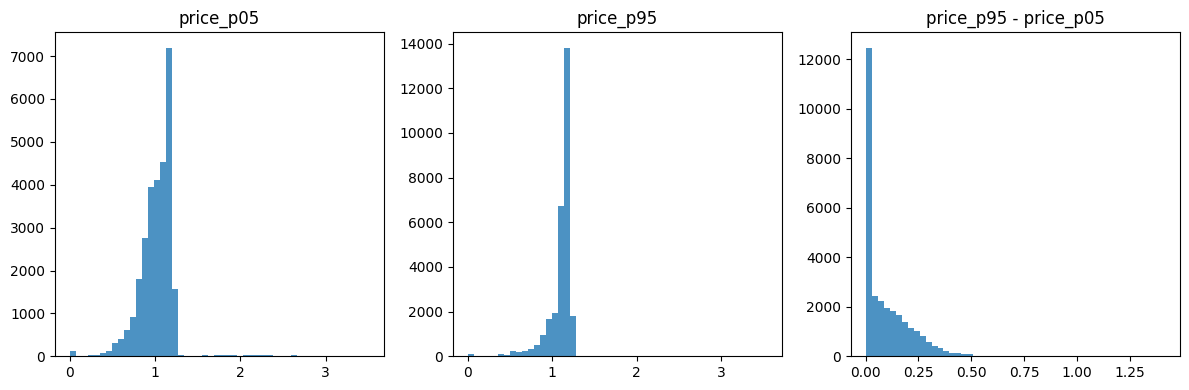

In [59]:
# Визуализация целей и ширины интервала
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].hist(train["price_p05"], bins=50, alpha=0.8)
axes[0].set_title("price_p05")

axes[1].hist(train["price_p95"], bins=50, alpha=0.8)
axes[1].set_title("price_p95")

axes[2].hist(width, bins=50, alpha=0.8)
axes[2].set_title("price_p95 - price_p05")

plt.tight_layout()


**Целевые переменные:**
- `price_p05` и `price_p95` валидны: случаев `price_p05 > price_p95` нет, минимальная ширина интервала ≈ 0.000109.
- Средние значения: `price_p05` ≈ 1.0215, `price_p95` ≈ 1.1169 (максимумы 3.512 и 3.547).
- Интервалы в целом узкие: доля ширины < 0.001 ≈ 34.2%, < 0.05 ≈ 49.4%, < 0.1 ≈ 62.6%.
- Есть 104 строки с `price_p05 = 0` (4 товара). Это создаёт экстремальные значения отношения `price_p95/price_p05`, поэтому при моделировании стоит учитывать нулевые нижние границы.


In [60]:
# Корреляции числовых признаков с целями
corr_cols = [
    "n_stores", "precpt", "avg_temperature", "avg_humidity", "avg_wind_level",
    "dow", "day_of_month", "week_of_year", "month", "holiday_flag", "activity_flag",
    "price_p05", "price_p95"
]

corr = train[corr_cols].corr()

corr[["price_p05", "price_p95"]].sort_values("price_p05", ascending=False)


,price_p05,price_p95
price_p05,1.000000,0.881660
price_p95,0.881660,1.000000
holiday_flag,-0.003438,-0.012772
dow,-0.006812,-0.014208
day_of_month,-0.010074,-0.005599
avg_humidity,-0.014149,0.022597
precpt,-0.021242,-0.006815
month,-0.030545,-0.024865
week_of_year,-0.036492,-0.027397
avg_wind_level,-0.045824,0.004875


**Корреляции с целями:**
- `price_p05` и `price_p95` сильно коррелируют между собой (≈ 0.882).
- Среди признаков наибольшую по модулю связь даёт `activity_flag` (отрицательная), а также слабая отрицательная связь у `n_stores`. Остальные числовые и календарные признаки имеют близкие к нулю корреляции.


In [61]:
# PSI для категориальных признаков
psi_cat_cols = [
    "management_group_id", "first_category_id", "second_category_id", "third_category_id",
    "dow", "day_of_month", "week_of_year", "month", "holiday_flag", "activity_flag", "product_id"
]

psi_cat = pd.DataFrame({
    "psi": [psi_categorical(train[c], test[c]) for c in psi_cat_cols],
    "train_unique": [train[c].nunique() for c in psi_cat_cols],
    "test_unique": [test[c].nunique() for c in psi_cat_cols],
}, index=psi_cat_cols).sort_values("psi", ascending=False)

psi_cat


,psi,train_unique,test_unique
week_of_year,8.846849,9,14
month,8.032251,3,4
product_id,4.200381,485,635
third_category_id,0.694057,197,197
first_category_id,0.141818,29,29
day_of_month,0.037467,31,31
second_category_id,0.032526,76,76
management_group_id,0.022401,7,7
dow,0.010653,7,7
holiday_flag,0.009094,2,2


**Сдвиги распределений (PSI) по категориальным признакам:**
- Наиболее сильный сдвиг в календарных признаках `week_of_year` и `month` (из-за продолжения периода теста).
- Существенный сдвиг в `product_id` объясняется появлением 150 новых товаров.
- Остальные категориальные признаки в целом стабильны, за исключением умеренного сдвига в `third_category_id`.


## Дополнительные анализы для пайплайна

Ниже — проверки и срезы, которые помогают выбрать стратегию валидации, обработку признаков и устойчивость модели.


**Проверка согласованности календарных признаков с `dt`**

In [62]:
calendar_checks = []
for name, df in [("train", train), ("test", test)]:
    derived = pd.DataFrame({
        "dow_from_dt": df["dt"].dt.dayofweek,
        "day_of_month_from_dt": df["dt"].dt.day,
        "month_from_dt": df["dt"].dt.month,
        "week_of_year_from_dt": df["dt"].dt.isocalendar().week.astype(int),
    })
    mismatches = {
        "dow_mismatch_rate": (df["dow"] != derived["dow_from_dt"]).mean(),
        "day_of_month_mismatch_rate": (df["day_of_month"] != derived["day_of_month_from_dt"]).mean(),
        "month_mismatch_rate": (df["month"] != derived["month_from_dt"]).mean(),
        "week_of_year_mismatch_rate": (df["week_of_year"] != derived["week_of_year_from_dt"]).mean(),
    }
    calendar_checks.append({"dataset": name, **mismatches})

calendar_checks = pd.DataFrame(calendar_checks).set_index("dataset")
calendar_checks


,dow_mismatch_rate,day_of_month_mismatch_rate,month_mismatch_rate,week_of_year_mismatch_rate
dataset,,,,
train,0.000000,0.000000,0.000000,0.000000
test,0.000000,0.000000,0.000000,0.000000


**Вывод:** календарные признаки полностью согласованы с `dt` (доля несовпадений 0% в train и test). Можно безопасно использовать их в моделях.


**Динамика целевых переменных по времени**

Диапазон дневных средних:


,min_daily_mean,max_daily_mean
price_p05,0.990828,1.046474
price_p95,1.076379,1.141956
width,0.085088,0.115216


Корреляция с порядком дат:


price_p05   -0.037391
price_p95   -0.029116
width        0.019453
dtype: float64

Помесячные средние:


,price_p05,price_p95,width
month,,,
3,1.040971,1.131873,0.090903
4,1.025400,1.120062,0.094662
5,1.013952,1.110942,0.096990


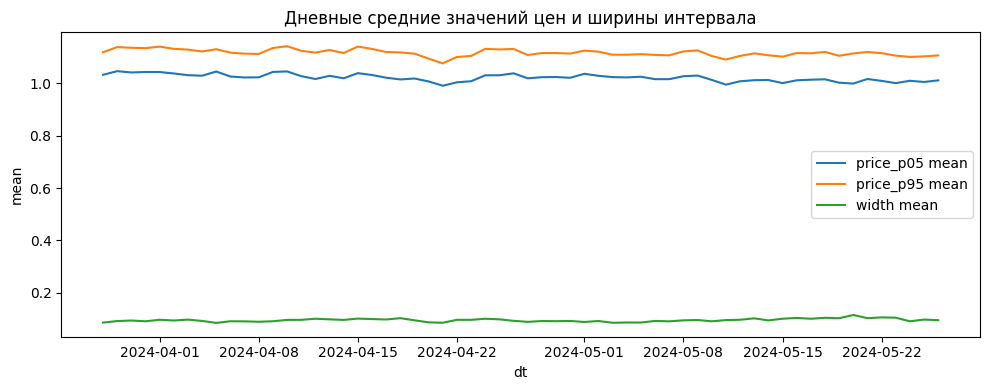

In [63]:
train = train.copy()
train["width"] = train["price_p95"] - train["price_p05"]

# дневные агрегаты
by_date = train.groupby("dt")[["price_p05", "price_p95", "width"]].agg(["mean", "median"])

by_date_mean = by_date.xs("mean", level=1, axis=1)
by_date_median = by_date.xs("median", level=1, axis=1)

# диапазон дневных средних
daily_mean_range = pd.DataFrame({
    "min_daily_mean": by_date_mean.min(),
    "max_daily_mean": by_date_mean.max(),
})

# корреляция с порядком дат
order = train["dt"].map({d: i for i, d in enumerate(sorted(train["dt"].unique()))})
trend_corr = pd.Series({
    col: train[col].corr(order) for col in ["price_p05", "price_p95", "width"]
})

# помесячные средние
by_month = train.groupby("month")[["price_p05", "price_p95", "width"]].mean()

print("Диапазон дневных средних:")
display(daily_mean_range)

print("Корреляция с порядком дат:")
display(trend_corr)

print("Помесячные средние:")
display(by_month)

# визуализация
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(by_date_mean.index, by_date_mean["price_p05"], label="price_p05 mean")
ax.plot(by_date_mean.index, by_date_mean["price_p95"], label="price_p95 mean")
ax.plot(by_date_mean.index, by_date_mean["width"], label="width mean")
ax.set_title("Дневные средние значений цен и ширины интервала")
ax.set_xlabel("dt")
ax.set_ylabel("mean")
ax.legend()
plt.tight_layout()


**Вывод:** дневные средние колеблются в узком диапазоне:
- `price_p05` ≈ 0.9908–1.0465,
- `price_p95` ≈ 1.0764–1.1420,
- ширина интервала ≈ 0.0851–0.1152.

Корреляции с порядком дат малы (`price_p05` ≈ -0.037, `price_p95` ≈ -0.029, ширина ≈ 0.019), то есть выраженного линейного тренда нет, но виден небольшой нисходящий сдвиг по месяцам:
- март: `price_p05` ≈ 1.0410, `price_p95` ≈ 1.1319,
- апрель: `price_p05` ≈ 1.0254, `price_p95` ≈ 1.1201,
- май: `price_p05` ≈ 1.0140, `price_p95` ≈ 1.1109.


**Стабильность цен по товарам**

Доля товаров с низкой вариативностью:


,share_cv_lt_0_1,share_cv_lt_0_05,share_cv_lt_0_01
price_p05_cv,0.119588,0.000000,0.000000
price_p95_cv,0.206186,0.002062,0.000000
width_cv,0.012371,0.000000,0.000000


Число NaN в CV (mean=0): 1
Квантили CV:


,count,mean,std,min,10%,25%,50%,75%,90%,max
price_p05_cv,484.000000,0.183330,0.101890,0.053838,0.096176,0.119464,0.159930,0.227122,0.301190,1.550459
price_p95_cv,485.000000,0.169890,0.094514,0.049457,0.080944,0.105399,0.144325,0.220694,0.298452,1.213886
width_cv,485.000000,1.225666,1.019082,0.064601,0.313322,0.518031,0.963731,1.578072,2.426601,6.417539


Самые стабильные по price_p05_cv (5 шт.):


,price_p05_cv,price_p95_cv,width_cv
product_id,,,
376,0.053838,0.050823,0.713213
400,0.056343,0.054933,2.731804
295,0.061473,0.049457,1.702047
441,0.061964,0.102923,0.898978
581,0.062286,0.062078,0.663271


Самые волатильные по price_p05_cv (5 шт.):


,price_p05_cv,price_p95_cv,width_cv
product_id,,,
625,0.424587,0.411691,1.720873
69,0.432107,0.219047,1.552195
121,0.459471,0.407594,0.393583
444,0.520339,0.320311,1.240108
452,1.550459,1.213886,1.213456


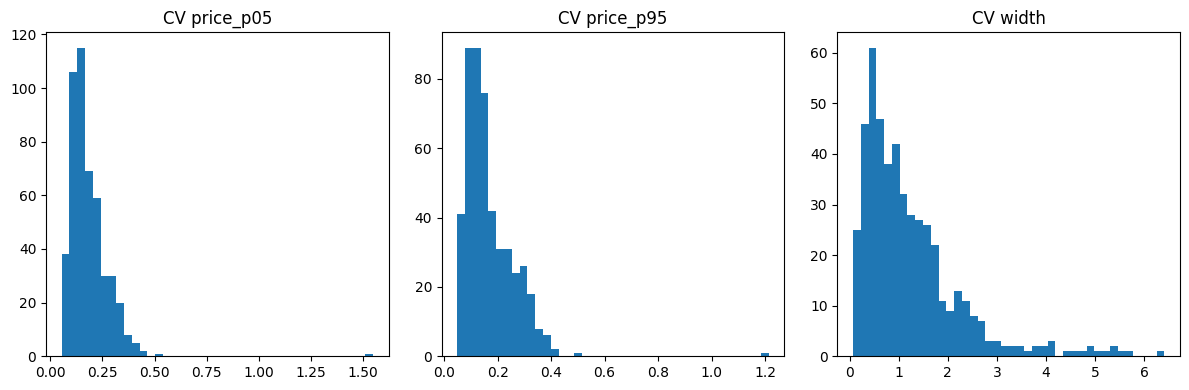

In [64]:
# коэффициенты вариации (std/mean) по товарам
agg = train.groupby("product_id")[["price_p05", "price_p95", "width"]].agg(["mean", "std"])
cv = pd.DataFrame({
    "price_p05_cv": agg[("price_p05", "std")] / agg[("price_p05", "mean")].replace(0, np.nan),
    "price_p95_cv": agg[("price_p95", "std")] / agg[("price_p95", "mean")].replace(0, np.nan),
    "width_cv": agg[("width", "std")] / agg[("width", "mean")].replace(0, np.nan),
})

share_cv = pd.DataFrame({
    "share_cv_lt_0_1": (cv < 0.1).mean(),
    "share_cv_lt_0_05": (cv < 0.05).mean(),
    "share_cv_lt_0_01": (cv < 0.01).mean(),
})

print("Доля товаров с низкой вариативностью:")
display(share_cv)

print("Число NaN в CV (mean=0):", cv["price_p05_cv"].isna().sum())

print("Квантили CV:")
display(cv.describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9]).T)

# примеры самых стабильных и самых волатильных по price_p05_cv
print("Самые стабильные по price_p05_cv (5 шт.):")
display(cv.sort_values("price_p05_cv").head(5))

print("Самые волатильные по price_p05_cv (5 шт.):")
display(cv.dropna().sort_values("price_p05_cv").tail(5))

# визуализация распределений CV
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].hist(cv["price_p05_cv"].dropna(), bins=40)
axes[0].set_title("CV price_p05")
axes[1].hist(cv["price_p95_cv"].dropna(), bins=40)
axes[1].set_title("CV price_p95")
axes[2].hist(cv["width_cv"].dropna(), bins=40)
axes[2].set_title("CV width")
plt.tight_layout()


**Вывод:** заметная часть товаров имеет умеренную вариативность, но «почти константных» товаров мало:
- доля `CV < 0.1`: `price_p05` ≈ 11.96%, `price_p95` ≈ 20.62%, ширина ≈ 1.24%.
- `CV < 0.05` почти не встречается.
- есть 1 товар со средней `price_p05 = 0` (CV не определён).

Для пайплайна это означает, что многие товары не являются «стабильными» и требуют учёта динамики/контекста.


**Категориальный сигнал и новые товары в test**

In [65]:
hier_cols = ["management_group_id", "first_category_id", "second_category_id", "third_category_id"]

category_summary = []
for col in hier_cols:
    grp = train.groupby(col)[["price_p05", "price_p95", "width"]].mean()
    category_summary.append({
        "feature": col,
        "n_categories": grp.shape[0],
        "price_p05_mean_min": grp["price_p05"].min(),
        "price_p05_mean_max": grp["price_p05"].max(),
        "price_p95_mean_min": grp["price_p95"].min(),
        "price_p95_mean_max": grp["price_p95"].max(),
        "width_mean_min": grp["width"].min(),
        "width_mean_max": grp["width"].max(),
    })

print("Диапазоны средних по уровням иерархии:")
display(pd.DataFrame(category_summary))

# сравнение распределений категорий для новых и старых товаров в test
train_products = set(train["product_id"].unique())
test_products = set(test["product_id"].unique())
new_products = test_products - train_products

new_test = test[test["product_id"].isin(new_products)]
old_test = test[test["product_id"].isin(train_products)]

for col in hier_cols:
    print(f"{col}: разница долей (новые - старые), топ-5")
    new_dist = new_test[col].value_counts(normalize=True)
    old_dist = old_test[col].value_counts(normalize=True)
    diff = (new_dist - old_dist).fillna(0)
    display(diff.sort_values(ascending=False).head(5).to_frame("share_diff"))
    display(diff.sort_values().head(5).to_frame("share_diff"))


Диапазоны средних по уровням иерархии:


,feature,n_categories,price_p05_mean_min,price_p05_mean_max,price_p95_mean_min,price_p95_mean_max,width_mean_min,width_mean_max
0,management_group_id,7,0.919058,1.072228,1.039779,1.151399,0.074749,0.120721
1,first_category_id,29,0.895893,1.162387,1.013340,1.198980,0.016459,0.162627
2,second_category_id,76,0.948831,1.064681,1.067922,1.151117,0.073355,0.126534
3,third_category_id,197,0.666123,1.187336,0.718329,1.267463,0.000455,0.263321


management_group_id: разница долей (новые - старые), топ-5


,share_diff
management_group_id,
1,0.067155
0,0.054882
3,0.009640
4,-0.013533
5,-0.025368


,share_diff
management_group_id,
6,-0.061840
2,-0.030937
5,-0.025368
4,-0.013533
3,0.009640


first_category_id: разница долей (новые - старые), топ-5


,share_diff
first_category_id,
7,0.071779
26,0.051674
24,0.048040
27,0.033601
9,0.020920


,share_diff
first_category_id,
17,-0.063823
18,-0.056300
8,-0.032331
2,-0.018436
3,-0.017487


second_category_id: разница долей (новые - старые), топ-5


,share_diff
second_category_id,
41,0.024291
22,0.020163
2,0.013416
52,0.009929
25,0.009883


,share_diff
second_category_id,
18,-0.015996
11,-0.014280
75,-0.013591
44,-0.012876
64,-0.011475


third_category_id: разница долей (новые - старые), топ-5


,share_diff
third_category_id,
149,0.035346
28,0.033039
148,0.032971
161,0.031356
160,0.027980


,share_diff
third_category_id,
176,-0.012067
177,-0.011924
34,-0.010277
42,-0.006426
128,-0.006082


**Вывод:** средние уровни цен различаются по иерархиям, особенно на уровне `third_category_id`:
- диапазон средних `price_p05` по `third_category_id`: ≈ 0.666–1.187,
- диапазон средних `price_p95` по `third_category_id`: ≈ 0.718–1.267,
- ширина по `third_category_id` меняется сильнее всего (≈ 0.0005–0.263).

Для новых товаров в test распределение категорий отличается от старых (например, в `management_group_id` больше доля категорий 1 и 0 и меньше 6 и 2, разница до ~6–7 п.п.). Это подтверждает категориальный сдвиг и необходимость устойчивой к нему модели.


**Эффект флагов `holiday_flag` и `activity_flag`**

In [66]:
for flag in ["holiday_flag", "activity_flag"]:
    print(f"{flag}")
    grp = train.groupby(flag)[["price_p05", "price_p95", "width"]].mean()
    display(grp)
    if 0 in grp.index and 1 in grp.index:
        diff = grp.loc[1] - grp.loc[0]
        print("Разница (1 - 0):")
        display(diff)

print("Совместный эффект флагов (2x2):")
flag_pivot = train.pivot_table(
    index="holiday_flag",
    columns="activity_flag",
    values=["price_p05", "price_p95", "width"],
    aggfunc="mean",
)
flag_pivot


holiday_flag


,price_p05,price_p95,width
holiday_flag,,,
0,1.022123,1.119211,0.097088
1,1.020361,1.112901,0.092540


Разница (1 - 0):


price_p05   -0.001762
price_p95   -0.006310
width       -0.004548
dtype: float64

activity_flag


,price_p05,price_p95,width
activity_flag,,,
0,1.100458,1.148450,0.047992
1,0.956559,1.090963,0.134404


Разница (1 - 0):


price_p05   -0.143899
price_p95   -0.057487
width        0.086412
dtype: float64

Совместный эффект флагов (2x2):


price_p05          price_p95             width         
activity_flag         0        1         0        1        0        1
holiday_flag                                                         
0              1.102810 0.954918  1.152274 1.091672 0.049464 0.136755
1              1.096315 0.959349  1.141712 1.089757 0.045397 0.130408

**Вывод:** `holiday_flag` почти не влияет на уровни цен (разница порядка -0.002 по `price_p05` и -0.006 по `price_p95`).

`activity_flag` влияет сильнее:
- при `activity_flag=1` средние `price_p05` и `price_p95` ниже (примерно на -0.144 и -0.057),
- ширина интервала выше примерно на +0.086.

Это подтверждает, что акции сопровождаются более широким диапазоном цен.


**Аномальные интервалы и соотношения `price_p95/price_p05`**

In [67]:
train["ratio"] = train["price_p95"] / train["price_p05"].replace(0, np.nan)

print("Топ-10 по ширине интервала:")
display(train.sort_values("width", ascending=False).head(10)[
    ["product_id", "dt", "price_p05", "price_p95", "width"]
])

print("Топ-10 по ratio (price_p95/price_p05):")
display(train.dropna(subset=["ratio"]).sort_values("ratio", ascending=False).head(10)[
    ["product_id", "dt", "price_p05", "price_p95", "ratio"]
])

thr = train["width"].quantile(0.995)
subset = train[train["width"] >= thr]

print("Ширина >= 99.5% квантиля:")
print("Порог:", thr)
print("Строк:", subset.shape[0])
print("Уникальных товаров:", subset["product_id"].nunique())

print("Товары с самыми частыми экстремальными ширинами:")
display(subset["product_id"].value_counts().head(5))

ratio_subset = train[train["ratio"] > 5]
print("ratio > 5:")
print("Строк:", ratio_subset.shape[0])
print("Уникальных товаров:", ratio_subset["product_id"].nunique())
print("Топ товаров:")
display(ratio_subset["product_id"].value_counts().head(5))


Топ-10 по ширине интервала:


,product_id,dt,price_p05,price_p95,width
12315,261,2024-04-12,1.521855,2.939901,1.418046
1495,31,2024-05-22,1.199150,2.536884,1.337734
3844,78,2024-04-01,1.990785,3.140103,1.149318
27306,591,2024-04-03,1.699355,2.815891,1.116536
27305,591,2024-04-02,1.489306,2.566866,1.077559
20880,452,2024-03-28,0.030608,1.079504,1.048896
27307,591,2024-04-04,1.582721,2.630765,1.048045
20894,452,2024-04-11,0.012657,1.053801,1.041144
20896,452,2024-04-13,0.028291,1.067832,1.039541
20910,452,2024-04-27,0.012732,1.051367,1.038635


Топ-10 по ratio (price_p95/price_p05):


,product_id,dt,price_p05,price_p95,ratio
20894,452,2024-04-11,0.012657,1.053801,83.255875
20910,452,2024-04-27,0.012732,1.051367,82.575651
3408,69,2024-05-15,0.008822,0.517708,58.683006
20899,452,2024-04-16,0.018850,1.048643,55.630574
20739,444,2024-05-06,0.009419,0.502109,53.310361
20896,452,2024-04-13,0.028291,1.067832,37.744704
20735,444,2024-05-02,0.013516,0.499397,36.948037
20893,452,2024-04-10,0.028792,1.060761,36.842689
20880,452,2024-03-28,0.030608,1.079504,35.268239
20898,452,2024-04-15,0.030467,1.034446,33.952696


Ширина >= 99.5% квантиля:
Порог: 0.5307827038811355
Строк: 146
Уникальных товаров: 55
Товары с самыми частыми экстремальными ширинами:


product_id
452    23
89     17
133     8
444     7
87      6
Name: count, dtype: int64

ratio > 5:
Строк: 36
Уникальных товаров: 4
Топ товаров:


product_id
452    23
133     7
69      4
444     2
Name: count, dtype: int64

**Вывод:** экстремальные интервалы концентрируются в ограниченном числе товаров:
- ширина выше 99.5% квантиля (≈ 0.5308) — 146 строк и всего 55 товаров; лидирует один товар (23 строки).
- отношение `price_p95/price_p05 > 5` встречается в 36 строках и всего у 4 товаров.

Эти аномалии стоит учитывать (например, в обработке выбросов или при построении robust‑моделей).


**Внутридневная вариативность числовых признаков**

In [68]:
num_cols = ["n_stores", "precpt", "avg_temperature", "avg_humidity", "avg_wind_level"]

rows = []
for name, df in [("train", train), ("test", test)]:
    for col in num_cols:
        uniq_by_date = df.groupby("dt")[col].nunique()
        rows.append({
            "dataset": name,
            "feature": col,
            "share_dates_unique1": (uniq_by_date == 1).mean(),
            "min_unique_per_date": uniq_by_date.min(),
            "median_unique_per_date": uniq_by_date.median(),
            "max_unique_per_date": uniq_by_date.max(),
        })

intra_day_variability = pd.DataFrame(rows)

intra_day_variability


,dataset,feature,share_dates_unique1,min_unique_per_date,median_unique_per_date,max_unique_per_date
0,train,n_stores,0.000000,485,485.000000,485
1,train,precpt,0.000000,485,485.000000,485
2,train,avg_temperature,0.000000,485,485.000000,485
3,train,avg_humidity,0.000000,485,485.000000,485
4,train,avg_wind_level,0.000000,485,485.000000,485
5,test,n_stores,0.000000,150,150.000000,635
6,test,precpt,0.000000,150,150.000000,635
7,test,avg_temperature,0.000000,150,150.000000,635
8,test,avg_humidity,0.000000,150,150.000000,635
9,test,avg_wind_level,0.000000,150,150.000000,635


**Вывод:** для всех числовых признаков доля дат с единственным значением равна 0. В train уникальных значений на дату ровно 485, в test — 150 или 635 (в зависимости от количества товаров в этот день). Это означает, что `n_stores` и погодные признаки меняются на уровне **товар × день**, а не являются общими для всей даты.


**Связь уровня цены и ширины интервала**

Корреляции:


width_vs_price_p05   -0.313046
width_vs_price_p95    0.172168
width_vs_mid_price   -0.077187
dtype: float64

Лог-шкала:


log_width_vs_log_mid   0.024703
dtype: float64

Ширина интервала по квартилям price_p05:


,mean,median,min,max
price_p05_q,,,,
0,0.191288,0.210968,0.000109,1.048896
1,0.123041,0.136111,0.000389,0.297588
2,0.045838,0.038672,0.000376,0.806264
3,0.021514,0.000465,0.000380,1.418046


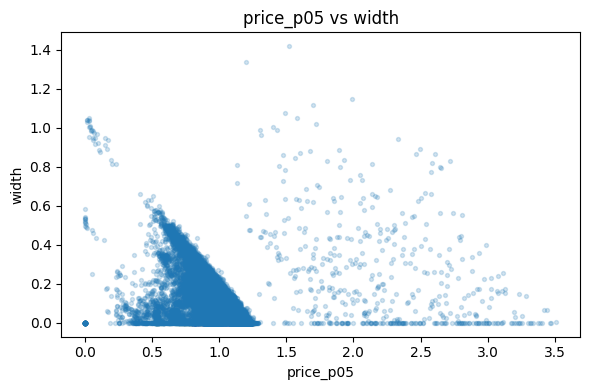

In [69]:
train = train.copy()
train["width"] = train["price_p95"] - train["price_p05"]
train["mid_price"] = (train["price_p05"] + train["price_p95"]) / 2

corrs = pd.Series({
    "width_vs_price_p05": train["width"].corr(train["price_p05"]),
    "width_vs_price_p95": train["width"].corr(train["price_p95"]),
    "width_vs_mid_price": train["width"].corr(train["mid_price"]),
})

train["log_width"] = np.log(train["width"] + 1e-6)
train["log_mid"] = np.log(train["mid_price"] + 1e-6)

corrs_log = pd.Series({
    "log_width_vs_log_mid": train["log_width"].corr(train["log_mid"])
})

print("Корреляции:")
display(corrs)
print("Лог-шкала:")
display(corrs_log)

train["price_p05_q"] = pd.qcut(train["price_p05"], 4, labels=False, duplicates="drop")
width_by_q = train.groupby("price_p05_q")["width"].describe()[["mean", "50%", "min", "max"]]
width_by_q = width_by_q.rename(columns={"50%": "median"})

print("Ширина интервала по квартилям price_p05:")
display(width_by_q)

# визуализация
fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(train["price_p05"], train["width"], s=8, alpha=0.2)
ax.set_xlabel("price_p05")
ax.set_ylabel("width")
ax.set_title("price_p05 vs width")
plt.tight_layout()


**Вывод:** ширина интервала отрицательно связана с `price_p05` (corr ≈ -0.313) и слабо — с `price_p95` (corr ≈ 0.172). В лог‑шкале связь почти отсутствует (≈ 0.025). По квартилям `price_p05` средняя ширина падает примерно с 0.191 (нижний квартиль) до 0.0215 (верхний квартиль), хотя остаются редкие экстремальные значения.


**Эффекты дня недели и номера недели**

Средние по dow:


,price_p05,price_p95,width
dow,,,
0,1.020020,1.118318,0.098297
1,1.023403,1.118792,0.095390
2,1.025349,1.123298,0.097949
3,1.022870,1.120040,0.097170
4,1.025062,1.117804,0.092742
5,1.017879,1.111756,0.093876
6,1.016239,1.109353,0.093114


Средние по week_of_year:


,price_p05,price_p95,width
week_of_year,,,
13,1.040971,1.131873,0.090903
14,1.033533,1.126191,0.092658
15,1.029137,1.124842,0.095705
16,1.017660,1.113372,0.095712
17,1.022046,1.117387,0.095341
18,1.026037,1.115075,0.089038
19,1.014972,1.109027,0.094054
20,1.009846,1.111342,0.101495
21,1.007445,1.109385,0.101939


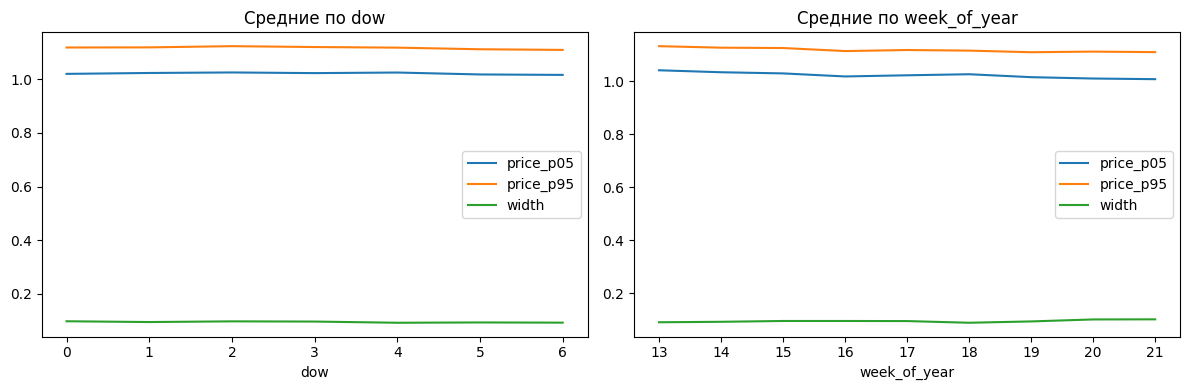

In [70]:
by_dow = train.groupby("dow")[["price_p05", "price_p95", "width"]].mean()
by_week = train.groupby("week_of_year")[["price_p05", "price_p95", "width"]].mean()

print("Средние по dow:")
display(by_dow)

print("Средние по week_of_year:")
display(by_week)

# визуализация
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
by_dow[["price_p05", "price_p95", "width"]].plot(ax=axes[0])
axes[0].set_title("Средние по dow")
axes[0].set_xlabel("dow")

by_week[["price_p05", "price_p95", "width"]].plot(ax=axes[1])
axes[1].set_title("Средние по week_of_year")
axes[1].set_xlabel("week_of_year")

plt.tight_layout()


**Вывод:** эффекты `dow` слабые (диапазон средних `price_p05` ≈ 1.016–1.025, ширина ≈ 0.0927–0.0983). По `week_of_year` колебания заметнее: `price_p05` ≈ 1.007–1.041, ширина ≈ 0.089–0.1019.


**Сдвиг внутри train: ранние vs поздние даты**

In [71]:
# первые 30 дат vs последние 30 дат
unique_dates = sorted(train["dt"].unique())
first_dates = set(unique_dates[:30])
last_dates = set(unique_dates[30:])

train_early = train[train["dt"].isin(first_dates)]
train_late = train[train["dt"].isin(last_dates)]

num_cols_shift = ["n_stores", "precpt", "avg_temperature", "avg_humidity", "avg_wind_level", "price_p05", "price_p95", "width"]
cat_cols_shift = [
    "management_group_id", "first_category_id", "second_category_id", "third_category_id",
    "dow", "week_of_year", "month", "holiday_flag", "activity_flag"
]

psi_num_train = pd.Series({
    col: psi_numeric(train_early[col], train_late[col]) for col in num_cols_shift
}).sort_values(ascending=False)

psi_cat_train = pd.Series({
    col: psi_categorical(train_early[col], train_late[col]) for col in cat_cols_shift
}).sort_values(ascending=False)

mean_diff = (train_late[num_cols_shift].mean() - train_early[num_cols_shift].mean())

print("PSI (числовые):")
display(psi_num_train)

print("PSI (категориальные):")
display(psi_cat_train)

print("Разница средних (поздние - ранние):")
display(mean_diff)


PSI (числовые):


avg_temperature   7.319478
avg_humidity      1.252474
precpt            0.297062
avg_wind_level    0.035157
price_p05         0.010790
price_p95         0.010168
width             0.004692
n_stores          0.000664
dtype: float64

PSI (категориальные):


week_of_year          21.853310
month                 14.795466
holiday_flag           0.077205
dow                    0.029752
third_category_id      0.015500
second_category_id     0.011597
activity_flag          0.003762
first_category_id      0.000929
management_group_id    0.000059
dtype: float64

Разница средних (поздние - ранние):


n_stores           0.000370
precpt            -0.112745
avg_temperature    0.956614
avg_humidity      -0.306282
avg_wind_level    -0.079089
price_p05         -0.012903
price_p95         -0.011283
width              0.001620
dtype: float64

**Вывод:** внутри train сильнее всего меняются погодные признаки (`avg_temperature` PSI ≈ 7.32, `avg_humidity` ≈ 1.25) и календарь (`week_of_year` ≈ 21.85, `month` ≈ 14.80). Целевые переменные почти не сдвигаются (PSI ≈ 0.01). Средние цены в поздней половине чуть ниже: `price_p05` ≈ -0.0129, `price_p95` ≈ -0.0113.


**Холодный старт: новые товары в test vs train**

In [72]:
train_products = set(train["product_id"].unique())
new_products = set(test["product_id"].unique()) - train_products

new_test = test[test["product_id"].isin(new_products)]
train_dates = set(train["dt"].unique())
new_test_overlap = new_test[new_test["dt"].isin(train_dates)]

num_cols_cold = ["n_stores", "precpt", "avg_temperature", "avg_humidity", "avg_wind_level"]

psi_new_all = pd.Series({
    col: psi_numeric(train[col], new_test[col]) for col in num_cols_cold
}).sort_values(ascending=False)

psi_new_overlap = pd.Series({
    col: psi_numeric(train[col], new_test_overlap[col]) for col in num_cols_cold
}).sort_values(ascending=False)

summary_cold = pd.DataFrame({
    "train_mean": train[num_cols_cold].mean(),
    "new_test_mean": new_test[num_cols_cold].mean(),
    "train_std": train[num_cols_cold].std(),
    "new_test_std": new_test[num_cols_cold].std(),
})

print("PSI (train vs новые товары, все даты):")
display(psi_new_all)

print("PSI (train vs новые товары, только пересекающиеся даты):")
display(psi_new_overlap)

print("Сравнение средних/стд:")
display(summary_cold)


PSI (train vs новые товары, все даты):


n_stores          1.073700
precpt            0.358407
avg_humidity      0.229243
avg_temperature   0.211979
avg_wind_level    0.042855
dtype: float64

PSI (train vs новые товары, только пересекающиеся даты):


n_stores          0.901038
precpt            0.188241
avg_humidity      0.085609
avg_temperature   0.044477
avg_wind_level    0.006720
dtype: float64

Сравнение средних/стд:


,train_mean,new_test_mean,train_std,new_test_std
n_stores,-0.002295,0.158223,0.989934,1.036400
precpt,-0.186648,0.161941,0.961778,1.034512
avg_temperature,-0.474845,0.175941,0.847154,1.027743
avg_humidity,-0.050176,0.082620,1.018483,1.053062
avg_wind_level,0.060413,0.073830,1.103594,0.974968


**Вывод:** для новых товаров в test наблюдается сдвиг по числовым признакам относительно train: сильнее всего по `n_stores` (PSI ≈ 1.07) и `precpt` (≈ 0.36). Если ограничиться пересекающимися датами, PSI падает (`avg_temperature` ≈ 0.04, `avg_humidity` ≈ 0.086), что подтверждает вклад сезонного фактора.

Средние значения у новых товаров выше (например, `avg_temperature` ≈ 0.176 против -0.475 в train), поэтому для холодного старта важно использовать контекстные признаки и устойчивые методы.


**Частота смен категорий и энтропия по товарам**

In [73]:
hier_cols = ["management_group_id", "first_category_id", "second_category_id", "third_category_id"]
train_sorted = train.sort_values(["product_id", "dt"])

change_rows = []
entropy_rows = []

for col in hier_cols:
    def count_changes(s):
        return (s != s.shift()).sum() - 1
    changes = train_sorted.groupby("product_id")[col].apply(count_changes)
    n_dates = train_sorted.groupby("product_id")["dt"].nunique().iloc[0]
    change_rate = changes / (n_dates - 1)

    change_rows.append({
        "feature": col,
        "mean_changes": changes.mean(),
        "median_changes": changes.median(),
        "min_changes": changes.min(),
        "max_changes": changes.max(),
        "share_no_changes": (changes == 0).mean(),
        "mean_change_rate": change_rate.mean(),
        "median_change_rate": change_rate.median(),
    })

    def entropy(s):
        counts = s.value_counts(normalize=True)
        return -(counts * np.log(counts)).sum()

    ent = train_sorted.groupby("product_id")[col].apply(entropy)
    entropy_rows.append({
        "feature": col,
        "mean_entropy": ent.mean(),
        "median_entropy": ent.median(),
        "min_entropy": ent.min(),
        "max_entropy": ent.max(),
    })

change_df = pd.DataFrame(change_rows)
entropy_df = pd.DataFrame(entropy_rows)

print("Смена категорий:")
display(change_df)

print("Энтропия распределений по товару:")
display(entropy_df)


Смена категорий:


,feature,mean_changes,median_changes,min_changes,max_changes,share_no_changes,mean_change_rate,median_change_rate
0,management_group_id,3.600000,4.000000,0,14,0.148454,0.061017,0.067797
1,first_category_id,5.744330,6.000000,0,15,0.030928,0.097362,0.101695
2,second_category_id,53.350515,54.000000,41,59,0.000000,0.904246,0.915254
3,third_category_id,29.459794,30.000000,17,42,0.000000,0.499319,0.508475


Энтропия распределений по товару:


,feature,mean_entropy,median_entropy,min_entropy,max_entropy
0,management_group_id,0.151699,0.169250,-0.000000,0.564148
1,first_category_id,0.194573,0.198515,-0.000000,0.450561
2,second_category_id,2.997440,3.010568,2.354477,3.485195
3,third_category_id,0.685549,0.690923,0.624331,0.693147


**Вывод:** частота смены категорий высока, особенно на уровне `second_category_id` (в среднем ≈ 53.35 смен, доля смен ≈ 0.904) и `third_category_id` (≈ 29.46 смен, доля ≈ 0.499). Для `management_group_id` есть ~14.85% товаров без смен.

Энтропия подтверждает разную степень «шумности»: низкая на `management_group_id` (~0.152) и `first_category_id` (~0.195), высокая на `second_category_id` (~2.997) и умеренная на `third_category_id` (~0.686).


**Выбросы в числовых признаках (IQR по train)**

In [74]:
num_cols_out = ["n_stores", "precpt", "avg_temperature", "avg_humidity", "avg_wind_level"]

bounds = {}
for col in num_cols_out:
    q1 = train[col].quantile(0.25)
    q3 = train[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    bounds[col] = (lower, upper)

rows = []
for col in num_cols_out:
    lower, upper = bounds[col]
    rows.append({
        "feature": col,
        "train_outlier_share": ((train[col] < lower) | (train[col] > upper)).mean(),
        "test_outlier_share": ((test[col] < lower) | (test[col] > upper)).mean(),
        "train_iqr_lower": lower,
        "train_iqr_upper": upper,
    })

outlier_df = pd.DataFrame(rows)

print("Доля выбросов по train-IQR:")
display(outlier_df[["feature", "train_outlier_share", "test_outlier_share"]])

# выбросы ширины интервала
q1 = train["width"].quantile(0.25)
q3 = train["width"].quantile(0.75)
iqr = q3 - q1
width_lower = q1 - 1.5 * iqr
width_upper = q3 + 1.5 * iqr
width_outlier_share = ((train["width"] < width_lower) | (train["width"] > width_upper)).mean()

print("Ширина интервала (train):")
print("outlier_share:", width_outlier_share)
print("lower:", width_lower)
print("upper:", width_upper)


Доля выбросов по train-IQR:


,feature,train_outlier_share,test_outlier_share
0,n_stores,0.116667,0.113583
1,precpt,0.113127,0.347807
2,avg_temperature,0.000000,0.000036
3,avg_humidity,0.130000,0.134046
4,avg_wind_level,0.011065,0.005062


Ширина интервала (train):
outlier_share: 0.02261168384879725
lower: -0.2324113763572661
upper: 0.3886037918748993


**Вывод:** по порогам IQR, рассчитанным на train, доля выбросов в test сопоставима для большинства признаков, но для `precpt` существенно выше (≈ 0.348 против 0.113). Это ещё один индикатор сдвига распределения.

Для ширины интервала доля выбросов ≈ 2.26% при границах IQR ≈ [-0.232, 0.389].


**Комбинации иерархий (пути категорий)**

In [75]:
hier_cols = ["management_group_id", "first_category_id", "second_category_id", "third_category_id"]

train_paths = train[hier_cols].astype(str).agg(">".join, axis=1)
test_paths = test[hier_cols].astype(str).agg(">".join, axis=1)

train_path_set = set(train_paths.unique())
test_path_set = set(test_paths.unique())

path_summary = pd.DataFrame({
    "n_unique": [train_paths.nunique(), test_paths.nunique()],
}, index=["train", "test"])

path_summary["share_unique"] = path_summary["n_unique"] / path_summary["n_unique"].sum()

print("Уникальных путей (train/test):")
display(path_summary)

print("Путей в test, отсутствующих в train:", len(test_path_set - train_path_set))
print("Путей в train, отсутствующих в test:", len(train_path_set - test_path_set))

# новые товары
train_products = set(train["product_id"].unique())
new_products = set(test["product_id"].unique()) - train_products
new_test = test[test["product_id"].isin(new_products)]

new_paths = new_test[hier_cols].astype(str).agg(">".join, axis=1)
new_path_set = set(new_paths.unique())

print("Уникальных путей у новых товаров:", new_paths.nunique())
print("Путей новых товаров, отсутствующих в train:", len(new_path_set - train_path_set))


Уникальных путей (train/test):


,n_unique,share_unique
train,13491,0.503866
test,13284,0.496134


Путей в test, отсутствующих в train: 7798
Путей в train, отсутствующих в test: 8005
Уникальных путей у новых товаров: 5757
Путей новых товаров, отсутствующих в train: 4452


**Вывод:** число уникальных «путей» (комбинаций 4‑х уровней) сопоставимо в train и test (≈ 13–14 тыс.), но пересечение неполное: около 58.7% путей в test отсутствуют в train. У новых товаров доля «новых» путей ещё выше (≈ 77.3%). Это означает сильный сдвиг по комбинациям категорий, и модели должны быть устойчивы к unseen‑комбинациям.


**Автокорреляция целей внутри товара (lag-1)**

Pooled корреляции (lag-1):


price_p05   0.668622
price_p95   0.599321
width       0.807524
dtype: float64

Per-product корреляции (lag-1):


,target,mean_corr,median_corr,share_corr_gt_0_5,share_corr_gt_0_7,share_corr_lt_0,nan_share
0,price_p05,0.444322,0.487084,0.476289,0.092784,0.080412,0.002062
1,price_p95,0.413047,0.477550,0.451546,0.057732,0.119588,0.000000
2,width,0.451896,0.484259,0.484536,0.251546,0.109278,0.000000


/Users/maksimlyara/Documents/GitHub/DL_competition_2025_N3/venv/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]


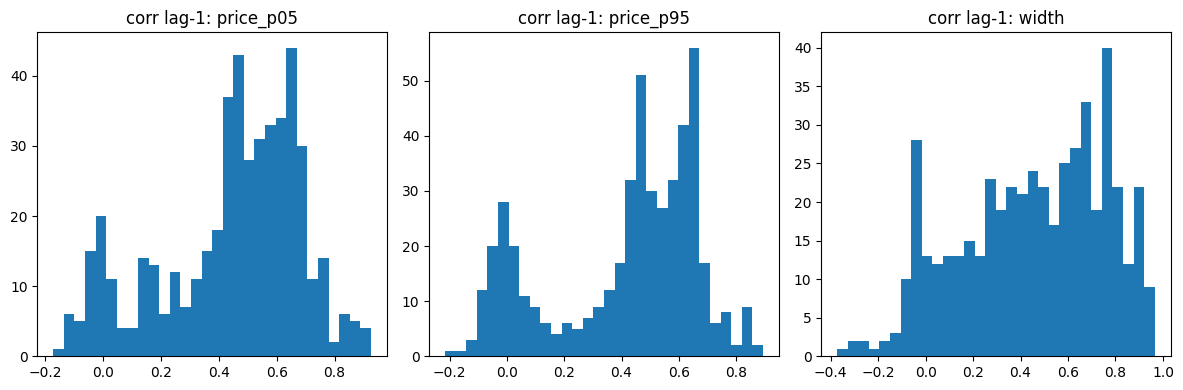

In [76]:
train = train.copy()
train["width"] = train["price_p95"] - train["price_p05"]
train_sorted = train.sort_values(["product_id", "dt"])

for col in ["price_p05", "price_p95", "width"]:
    train_sorted[f"{col}_lag1"] = train_sorted.groupby("product_id")[col].shift(1)

# pooled корреляция по всем строкам
pooled_corr = pd.Series({
    col: train_sorted[col].corr(train_sorted[f"{col}_lag1"]) for col in ["price_p05", "price_p95", "width"]
})

# per-product корреляции
import warnings

per_product_rows = []
with warnings.catch_warnings():
    warnings.simplefilter("ignore", RuntimeWarning)
    for col in ["price_p05", "price_p95", "width"]:
        corrs = train_sorted.groupby("product_id")[col].apply(lambda s: s.corr(s.shift(1)))
        per_product_rows.append({
            "target": col,
            "mean_corr": corrs.mean(),
            "median_corr": corrs.median(),
            "share_corr_gt_0_5": (corrs > 0.5).mean(),
            "share_corr_gt_0_7": (corrs > 0.7).mean(),
            "share_corr_lt_0": (corrs < 0).mean(),
            "nan_share": corrs.isna().mean(),
        })

per_product_corr = pd.DataFrame(per_product_rows)

print("Pooled корреляции (lag-1):")
display(pooled_corr)

print("Per-product корреляции (lag-1):")
display(per_product_corr)

# распределения per-product корреляций
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i, col in enumerate(["price_p05", "price_p95", "width"]):
    corrs = train_sorted.groupby("product_id")[col].apply(lambda s: s.corr(s.shift(1)))
    axes[i].hist(corrs.dropna(), bins=30)
    axes[i].set_title(f"corr lag-1: {col}")
plt.tight_layout()


**Вывод:** заметна временная зависимость внутри товара. Pooled корреляция lag‑1 составляет примерно 0.669 для `price_p05`, 0.599 для `price_p95` и 0.808 для ширины интервала. По товарам медианные lag‑1 корреляции около 0.487 (p05), 0.478 (p95), 0.484 (width); доля товаров с corr > 0.5 — около 45–48%. Это говорит о пользе лаговых/скользящих признаков и time‑validation.


**Вариативность контекстных признаков по товарам**

Уникальные значения по товарам (min/median/max):


,min,median,max
n_stores,60.000000,60.000000,60.000000
precpt,60.000000,60.000000,60.000000
avg_temperature,60.000000,60.000000,60.000000
avg_humidity,60.000000,60.000000,60.000000
avg_wind_level,60.000000,60.000000,60.000000


Стандартные отклонения по товарам (min/median/max):


,min,median,max
n_stores,0.026307,0.035888,0.046349
precpt,0.102402,0.230975,1.667758
avg_temperature,0.170332,0.668876,0.806455
avg_humidity,0.169525,0.306037,0.461566
avg_wind_level,0.421480,0.690823,1.483456


Доля товаров с nunique == 1:


n_stores          0.000000
precpt            0.000000
avg_temperature   0.000000
avg_humidity      0.000000
avg_wind_level    0.000000
dtype: float64

Доля товаров со std < 0.1:


n_stores          1.000000
precpt            0.000000
avg_temperature   0.000000
avg_humidity      0.000000
avg_wind_level    0.000000
dtype: float64

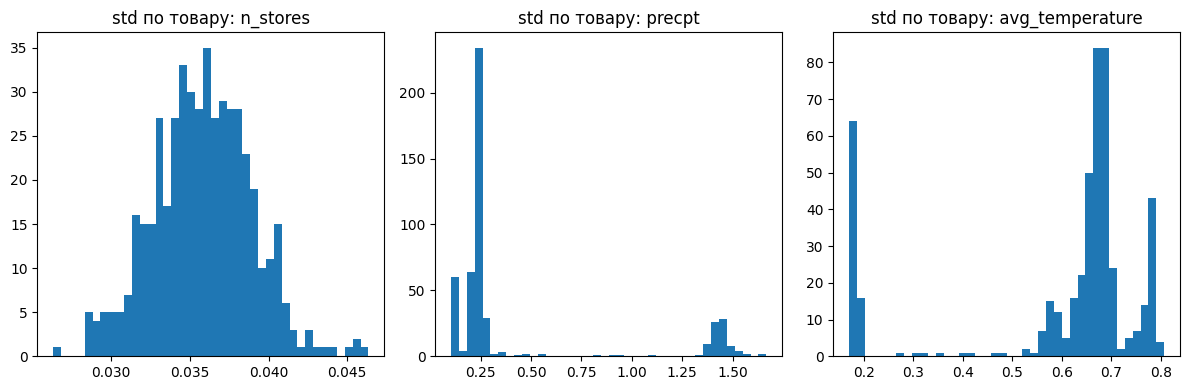

In [77]:
context_cols = ["n_stores", "precpt", "avg_temperature", "avg_humidity", "avg_wind_level"]

nunique = train.groupby("product_id")[context_cols].nunique()
std = train.groupby("product_id")[context_cols].std()

summary_nunique = nunique.describe().T[["min", "50%", "max"]].rename(columns={"50%": "median"})
summary_std = std.describe().T[["min", "50%", "max"]].rename(columns={"50%": "median"})

share_single = (nunique == 1).mean()
share_low_std = (std < 0.1).mean()

print("Уникальные значения по товарам (min/median/max):")
display(summary_nunique)

print("Стандартные отклонения по товарам (min/median/max):")
display(summary_std)

print("Доля товаров с nunique == 1:")
display(share_single)

print("Доля товаров со std < 0.1:")
display(share_low_std)

# визуализация std
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes = axes.ravel()
for i, col in enumerate(context_cols[:3]):
    axes[i].hist(std[col], bins=40)
    axes[i].set_title(f"std по товару: {col}")
plt.tight_layout()


**Вывод:** для каждого товара в train все контекстные признаки имеют 60 уникальных значений (по числу дней), то есть меняются ежедневно. При этом `n_stores` почти константен в разрезе товара (std < 0.1 у 100% товаров, медианный std ≈ 0.0359), а погодные признаки имеют заметную вариативность (медианные std ≈ 0.231–0.691). Это намекает на разную природу этих признаков: `n_stores` ближе к товарному атрибуту, погода — к ежедневному контексту.


**PCA по числовым признакам (train vs test)**

Explained variance ratio:


,component,explained_variance_ratio
0,PC1,0.338331
1,PC2,0.257474


Суммарно: 0.5958056267876732
Средние координаты:


,dataset,pc1_mean,pc2_mean
0,train,-0.000000,-0.000000
1,test,1.208958,-0.031414


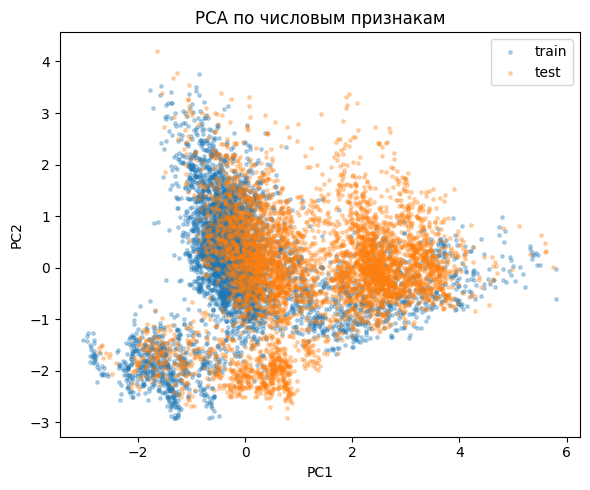

In [78]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

num_cols_pca = ["n_stores", "precpt", "avg_temperature", "avg_humidity", "avg_wind_level"]

scaler = StandardScaler()
X_train = scaler.fit_transform(train[num_cols_pca])
X_test = scaler.transform(test[num_cols_pca])

pca = PCA(n_components=2, random_state=42)
train_pca = pca.fit_transform(X_train)
test_pca = pca.transform(X_test)

pca_info = pd.DataFrame({
    "component": ["PC1", "PC2"],
    "explained_variance_ratio": pca.explained_variance_ratio_,
})

print("Explained variance ratio:")
display(pca_info)
print("Суммарно:", pca.explained_variance_ratio_.sum())

pca_means = pd.DataFrame({
    "dataset": ["train", "test"],
    "pc1_mean": [train_pca[:, 0].mean(), test_pca[:, 0].mean()],
    "pc2_mean": [train_pca[:, 1].mean(), test_pca[:, 1].mean()],
})

print("Средние координаты:")
display(pca_means)

# scatter на подвыборке
rng = np.random.default_rng(42)
train_idx = rng.choice(len(train_pca), size=min(5000, len(train_pca)), replace=False)
test_idx = rng.choice(len(test_pca), size=min(5000, len(test_pca)), replace=False)

fig, ax = plt.subplots(figsize=(6, 5))
ax.scatter(train_pca[train_idx, 0], train_pca[train_idx, 1], s=6, alpha=0.3, label="train")
ax.scatter(test_pca[test_idx, 0], test_pca[test_idx, 1], s=6, alpha=0.3, label="test")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_title("PCA по числовым признакам")
ax.legend()
plt.tight_layout()


**Вывод:** первые две компоненты объясняют около 59.6% дисперсии (PC1 ≈ 0.338, PC2 ≈ 0.257). Среднее значение PC1 в test существенно смещено относительно train (≈ +1.21), что подтверждает распределительный сдвиг по числовым признакам.


**Кластеризация товаров по динамике цен**

In [79]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings

train_feat = train.copy()
train_feat["width"] = train_feat["price_p95"] - train_feat["price_p05"]
train_sorted = train_feat.sort_values(["product_id", "dt"])

for col in ["price_p05", "price_p95", "width"]:
    train_sorted[f"{col}_lag1"] = train_sorted.groupby("product_id")[col].shift(1)

# агрегаты по товарам
agg = train_feat.groupby("product_id")[["price_p05", "price_p95", "width"]].agg(["mean", "std", "median"])
agg.columns = ["_".join(col).strip() for col in agg.columns.values]

# lag-корреляции по товарам
with warnings.catch_warnings():
    warnings.simplefilter("ignore", RuntimeWarning)
    warnings.simplefilter("ignore", FutureWarning)
    lag_corr = train_sorted.groupby("product_id").apply(
        lambda df: pd.Series({
            "price_p05_lag_corr": df["price_p05"].corr(df["price_p05_lag1"]),
            "price_p95_lag_corr": df["price_p95"].corr(df["price_p95_lag1"]),
            "width_lag_corr": df["width"].corr(df["width_lag1"]),
        })
    )

features = agg.join(lag_corr).fillna(0)

scaler_prod = StandardScaler()
X_prod = scaler_prod.fit_transform(features)

silhouette = {}
for k in range(2, 9):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_prod)
    silhouette[k] = silhouette_score(X_prod, labels)

silhouette_series = pd.Series(silhouette).sort_index()
print("Silhouette score по k:")
display(silhouette_series)

best_k = silhouette_series.idxmax()
print("Лучшее k:", best_k)

kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_prod)

cluster_sizes = pd.Series(labels).value_counts().sort_index()
print("Размеры кластеров:")
display(cluster_sizes)

cluster_summary = features.copy()
cluster_summary["cluster"] = labels
cluster_means = cluster_summary.groupby("cluster")[["price_p05_mean", "price_p95_mean", "width_mean", "width_std"]].mean()

print("Средние по кластерам:")
display(cluster_means)


Silhouette score по k:


2   0.254502
3   0.223737
4   0.235254
5   0.227182
6   0.230893
7   0.232795
8   0.215791
dtype: float64

Лучшее k: 2
Размеры кластеров:


0    322
1    163
Name: count, dtype: int64

Средние по кластерам:


,price_p05_mean,price_p95_mean,width_mean,width_std
cluster,,,,
0,1.095299,1.146503,0.051204,0.050254
1,0.875645,1.058413,0.182768,0.094425


**Вывод:** оптимальное число кластеров по silhouette — 2 (score ≈ 0.255). Кластеры различаются прежде всего по ширине интервала:
- кластер 0: более высокие средние цены и узкая ширина,
- кластер 1: более низкий `price_p05` и заметно более широкие интервалы.


**Детекция аномалий товаров (IsolationForest)**

Топ-10 аномальных товаров:


,product_id,anomaly_score
348,452,0.245175
48,60,0.218681
227,291,0.131088
56,69,0.112852
455,591,0.101868
309,392,0.082152
477,624,0.066674
345,444,0.065154
73,89,0.057785
469,613,0.056014


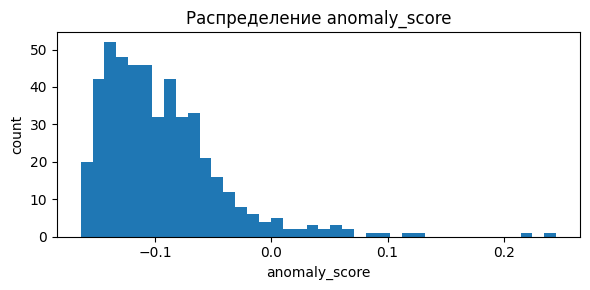

In [80]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(n_estimators=300, contamination=0.05, random_state=42)
iso.fit(X_prod)

anomaly_score = -iso.decision_function(X_prod)

anomaly_df = pd.DataFrame({
    "product_id": features.index,
    "anomaly_score": anomaly_score,
}).sort_values("anomaly_score", ascending=False)

print("Топ-10 аномальных товаров:")
display(anomaly_df.head(10))

# распределение скора
fig, ax = plt.subplots(figsize=(6, 3))
ax.hist(anomaly_score, bins=40)
ax.set_title("Распределение anomaly_score")
ax.set_xlabel("anomaly_score")
ax.set_ylabel("count")
plt.tight_layout()


**Вывод:** среди топ‑аномалий появляются товары, которые уже выделялись по экстремальной ширине/отношениям цен (например, `product_id` 452, 60, 69, 591). Это подтверждает согласованность с предыдущим анализом выбросов.


## Итоги EDA

Ключевые выводы:
- Данные чистые: нет пропусков и дубликатов по ключу `product_id + dt`.
- Train — полный прямоугольник 485×60; test состоит из новых товаров на всём горизонте и старых товаров только в будущих датах.
- Категориальные иерархии **не закреплены** за товаром и меняются по датам, поэтому их нужно рассматривать как полноценные динамические признаки.
- Календарные признаки полностью согласованы с `dt` (0% несовпадений).
- Числовые контекстные признаки меняются на уровне **товар × день**: внутри одной даты уникальные значения равны числу товаров.
- Временной сдвиг (доп. недели и месяц) и распределительный сдвиг в погодных признаках и `n_stores` выражены сильно.
- Целевые интервалы в основном узкие, но есть отдельные случаи с нулевой нижней границей; экстремальные интервалы концентрируются в нескольких товарах.
- По времени наблюдается слабый нисходящий сдвиг средних цен от марта к маю, без выраженного линейного тренда.
- Эффект `activity_flag` заметен (снижение средних цен и рост ширины интервала), `holiday_flag` почти нейтрален.
- Внутри train сильный сезонный сдвиг по погоде (`avg_temperature`, `avg_humidity`) и календарю (`week_of_year`, `month`), при этом цели стабильнее.
- Новые товары в test имеют сдвиги в числовых признаках относительно train; часть сдвига объясняется сезонностью.
- Частота смены категорий особенно высокая на уровне `second_category_id` и `third_category_id`.
- По IQR‑критериям в test заметно больше выбросов для `precpt`.
- Комбинации иерархий (пути) сильно сдвинуты: ~58.7% путей test отсутствуют в train, у новых товаров доля ещё выше (~77.3%).
- Внутритоварная автокорреляция целей заметна (lag‑1 pooled corr: ~0.67 для `price_p05`, ~0.60 для `price_p95`, ~0.81 для ширины).
- `n_stores` почти константен в разрезе товара, тогда как погодные признаки заметно меняются во времени.
- PCA по числовым признакам фиксирует сдвиг test относительно train (смещение PC1); кластеризация товаров выделяет 2 группы по ширине интервала; аномалии по IsolationForest совпадают с экстремальными товарами.

Эта структура влияет на выбор валидации: при оценке качества в train важно учитывать временную природу, наличие новых товаров и сдвиги в признаках.
